## A little bit of pre-work (cheating?) to get data into a better form - spark wasn't reading in the csv correctly...

In [1]:
import pandas as pd

In [2]:
pd_df = pd.read_csv('../data/Consumer_Complaints.csv')

//anaconda3/envs/pyspark-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd_df.count()

Date received                   1474568
Product                         1474568
Sub-product                     1239403
Issue                           1474568
Sub-issue                        919291
Consumer complaint narrative     482567
Company public response          550042
Company                         1474568
State                           1450021
ZIP code                        1337072
Tags                             200924
Consumer consent provided?       865482
Submitted via                   1474568
Date sent to company            1474568
Company response to consumer    1474567
Timely response?                1474568
Consumer disputed?               768480
Complaint ID                    1474568
dtype: int64

In [4]:
pd_df.head(5).T

,0,1,2,3,4
Date received,08/09/2015,02/06/2014,01/29/2019,11/03/2019,08/19/2015
Product,Credit reporting,Mortgage,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Mortgage
Sub-product,NaN,Other mortgage,Credit reporting,Credit reporting,Conventional adjustable mortgage (ARM)
Issue,Incorrect information on credit report,"Loan modification,collection,foreclosure",Problem with a credit reporting company's inve...,Problem with a credit reporting company's inve...,"Loan servicing, payments, escrow account"
Sub-issue,Information is not mine,NaN,Was not notified of investigation status or re...,Their investigation did not fix an error on yo...,NaN
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,Company chooses not to provide a public response,NaN,NaN,NaN,Company chooses not to provide a public response
Company,Experian Information Solutions Inc.,Ocwen Financial Corporation,"EQUIFAX, INC.","EQUIFAX, INC.",WELLS FARGO & COMPANY
State,NJ,CA,NY,SC,CA
ZIP code,08872,939XX,10801,290XX,94526


## Saving csv as paraquet to see if it solves csv reading problem
### you need to conda install pyarrow or fastparquet

First, I'll fix some column names - Spark / Paraquet doesn't work well with spaces.

In [5]:
pd_df.columns = [col.lower().replace(' ', '_') for col in pd_df.columns]

In [6]:
pd_df.to_parquet('../data/consumer_complaints.parquet')

## Now we're ready to take Spark's DataFrames for a spin

### Import necessary packages

In [7]:
import pyspark

With base Spark, you would start with a SparkContext - sets up your Spark application by connecting to the execution environment. For example, if the execution environment is running on my local machine with all cores.

But for Spark DataFrames, you'll need a SparkSession, and it will set up the context for you.

In [8]:
# sc = pyspark.SparkContext('local[*]')

## To make a data frame, DON'T make your SparkContext first, instead, allow the SparkSession to establish the connection

In [9]:
spark = pyspark.sql.SparkSession \
    .builder \
    .master('local[*]') \
    .appName("Python Spark Consumer Complaints example") \
    .getOrCreate()

Quick Check of the Number of Cores I'm using

In [10]:
spark.sparkContext.defaultParallelism

4

## Import data from parquet into DataFrame

In [11]:
df = spark.read.load('../data/consumer_complaints.parquet',
                     inferSchema="true", header="true")

In [12]:
df.dtypes

[('date_received', 'string'),
 ('product', 'string'),
 ('sub-product', 'string'),
 ('issue', 'string'),
 ('sub-issue', 'string'),
 ('consumer_complaint_narrative', 'string'),
 ('company_public_response', 'string'),
 ('company', 'string'),
 ('state', 'string'),
 ('zip_code', 'string'),
 ('tags', 'string'),
 ('consumer_consent_provided?', 'string'),
 ('submitted_via', 'string'),
 ('date_sent_to_company', 'string'),
 ('company_response_to_consumer', 'string'),
 ('timely_response?', 'string'),
 ('consumer_disputed?', 'string'),
 ('complaint_id', 'bigint')]

In [13]:
df.head()

Row(date_received='08/09/2015', product='Credit reporting', sub-product=None, issue='Incorrect information on credit report', sub-issue='Information is not mine', consumer_complaint_narrative=None, company_public_response='Company chooses not to provide a public response', company='Experian Information Solutions Inc.', state='NJ', zip_code='08872', tags=None, consumer_consent_provided?='Consent not provided', submitted_via='Web', date_sent_to_company='08/09/2015', company_response_to_consumer='Closed with non-monetary relief', timely_response?='Yes', consumer_disputed?='No', complaint_id=1509954)

In [14]:
df.count()

1474568

In [15]:
companies = df[['date_received', 'company']]
companies.head(5)

[Row(date_received='08/09/2015', company='Experian Information Solutions Inc.'),
 Row(date_received='02/06/2014', company='Ocwen Financial Corporation'),
 Row(date_received='01/29/2019', company='EQUIFAX, INC.'),
 Row(date_received='11/03/2019', company='EQUIFAX, INC.'),
 Row(date_received='08/19/2015', company='WELLS FARGO & COMPANY')]

SQL-style viewing of dataframe head

In [16]:
df.show(n=5, truncate=False, vertical=True)


-RECORD 0--------------------------------------------------------------------------------------------------------
 date_received                | 08/09/2015                                                                       
 product                      | Credit reporting                                                                 
 sub-product                  | null                                                                             
 issue                        | Incorrect information on credit report                                           
 sub-issue                    | Information is not mine                                                          
 consumer_complaint_narrative | null                                                                             
 company_public_response      | Company chooses not to provide a public response                                 
 company                      | Experian Information Solutions Inc.                     

In [17]:
companies.show(n=5, truncate=False)

+-------------+-----------------------------------+
|date_received|company                            |
+-------------+-----------------------------------+
|08/09/2015   |Experian Information Solutions Inc.|
|02/06/2014   |Ocwen Financial Corporation        |
|01/29/2019   |EQUIFAX, INC.                      |
|11/03/2019   |EQUIFAX, INC.                      |
|08/19/2015   |WELLS FARGO & COMPANY              |
+-------------+-----------------------------------+
only showing top 5 rows



## Now that we have our data frame, let's go ahead and use it to answer some questions:

* Which companies got the most complaints?
* What time frame are we looking at?
* How many complaints do we have total? Per day?
* How are the complaints received?
* Are the responses timely?
* Do they get disputed?

#### Companies with the most complaints

In [18]:
company_counts = df.groupBy('company').count()

company_counts_for_graph = company_counts.filter(company_counts['count'] >1000) \
    .sort('count', ascending=False).toPandas()


In [19]:
list(company_counts_for_graph[0:20]['company'])

['EQUIFAX, INC.',
 'Experian Information Solutions Inc.',
 'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'WELLS FARGO & COMPANY',
 'JPMORGAN CHASE & CO.',
 'CITIBANK, N.A.',
 'CAPITAL ONE FINANCIAL CORPORATION',
 'Navient Solutions, LLC.',
 'Ocwen Financial Corporation',
 'SYNCHRONY FINANCIAL',
 'NATIONSTAR MORTGAGE',
 'U.S. BANCORP',
 'AMERICAN EXPRESS COMPANY',
 'Ditech Financial LLC',
 'PNC Bank N.A.',
 'ENCORE CAPITAL GROUP INC.',
 'PORTFOLIO RECOVERY ASSOCIATES INC',
 'DISCOVER BANK',
 'TD BANK US HOLDING COMPANY']

In [20]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

//anaconda3/envs/pyspark-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


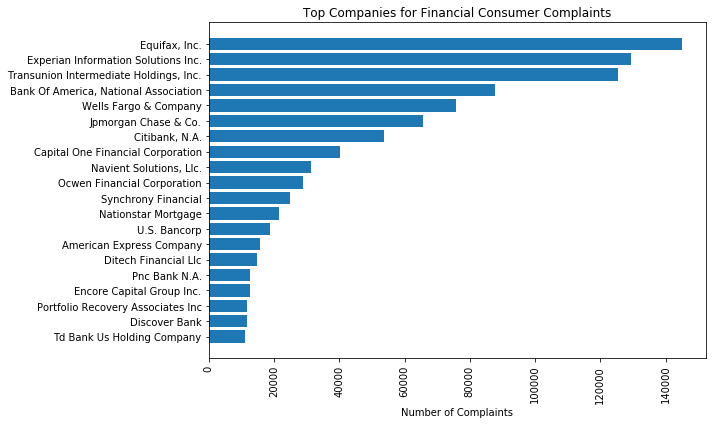

In [21]:
counts = company_counts_for_graph[0:20]
counts['company'] = [x.title() for x in counts['company']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(y=counts['company'], 
       width=counts['count'])
ax.set_title("Top Companies for Financial Consumer Complaints")
ax.set_xlabel("Number of Complaints")
plt.xticks(rotation=90)
ax.invert_yaxis()

plt.savefig('images/company_counts.png')

### Get First and Last Dates

In [22]:
from pyspark.sql.functions import to_date

first_date = df.select(to_date(df.date_received, 'MM/dd/yyyy').alias('date')) \
    .orderBy('date').take(1)
first_date

[Row(date=datetime.date(2011, 12, 1))]

In [23]:
last_date = df.select(to_date(df.date_received, 'MM/dd/yyyy').alias('date')) \
    .orderBy('date', ascending=False).take(1)
last_date

[Row(date=datetime.date(2020, 1, 12))]

#### Get Complaints total, average day, per day

In [24]:
days = last_date[0]['date']-first_date[0]['date']

In [25]:
days

datetime.timedelta(days=2964)

In [26]:
df.count()

1474568

In [27]:
df.count()/days.days

497.49257759784075

In [28]:
dates = df.select(to_date(df.date_received, 'MM/dd/yyyy').alias('date'))

In [29]:
dates.sort('date').show(10)

+----------+
|      date|
+----------+
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
|2011-12-01|
+----------+
only showing top 10 rows



In [30]:
complaints_per_day_pd = dates.groupBy('date').count().sort('date').toPandas()

//anaconda3/envs/pyspark-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


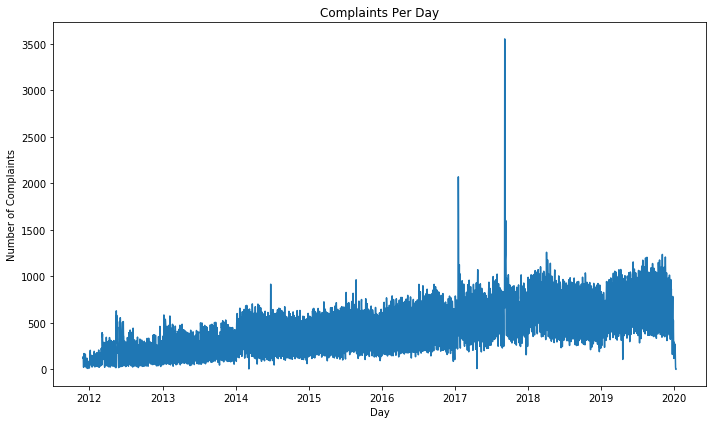

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(complaints_per_day_pd['date'], complaints_per_day_pd['count'])
ax.set_title("Complaints Per Day")
ax.set_xlabel("Day")
ax.set_ylabel("Number of Complaints")

plt.savefig('images/daily_complaints.png')
plt.show();

In [32]:
daily_complaint_counts = dates.groupBy('date').count()
daily_complaint_counts.filter(daily_complaint_counts['count'] > 1500) \
    .orderBy('date').show()

+----------+-----+
|      date|count|
+----------+-----+
|2017-01-19| 2070|
|2017-01-20| 1633|
|2017-09-08| 3553|
|2017-09-09| 2709|
|2017-09-13| 1600|
+----------+-----+



#### How are the complaints recieved?
#### Are the responses timely?
#### Do they get disputed?

In [33]:
df.groupBy('submitted_via').count().sort('count', ascending=False).show()
df.groupBy('timely_response?').count().sort('count', ascending=False).show()
df.groupBy('consumer_disputed?').count().sort('count', ascending=False).show()

+-------------+-------+
|submitted_via|  count|
+-------------+-------+
|          Web|1106079|
|     Referral| 187007|
|        Phone|  88292|
|  Postal mail|  72485|
|          Fax|  20297|
|        Email|    408|
+-------------+-------+

+----------------+-------+
|timely_response?|  count|
+----------------+-------+
|             Yes|1439485|
|              No|  35083|
+----------------+-------+

+------------------+------+
|consumer_disputed?| count|
+------------------+------+
|              null|706088|
|                No|620102|
|               Yes|148378|
+------------------+------+



## Shut down the SparkSession

In [34]:
spark.stop()